In [ ]:
from pangea_client.client import Client
from pangea_client.types import Format
from dotenv import load_dotenv
import nest_asyncio
import json
import polars as pl
import matplotlib.pyplot as plt
import datetime

nest_asyncio.apply()

# add PANGEA_USERNAME and PANGEA_PASSWORD in .env
load_dotenv(override=True)

True

In [ ]:
# pangea client request returning polars dataframe
async def fetch_univ3_prices(from_block, to_block, pool_address):
    async with Client() as client:
        handle = await client.get_uniswap_v3_prices(
            params={
                "chains": ["ETH"],
                "from_block": from_block,
                "to_block": to_block,
                "pool_address__in": pool_address
            },
            format=Format.JsonStream,
        )

        records = []
        async for chunk in handle:
            for line in chunk.strip().splitlines():
                if line:
                    records.append(json.loads(line))

    return pl.from_dicts(records) if records else pl.DataFrame()

In [ ]:
# fetch latest 10k blocks for univ3 weth-usdc 5bps pool
df = await fetch_univ3_prices(-10000, "latest", "0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640")

In [ ]:
# convert unix timestamp to datetime
df = df.with_columns(
    pl.col("timestamp").map_elements(
        lambda x: datetime.datetime.fromtimestamp(x, tz=datetime.timezone.utc),
        return_dtype=pl.Datetime
    )
)

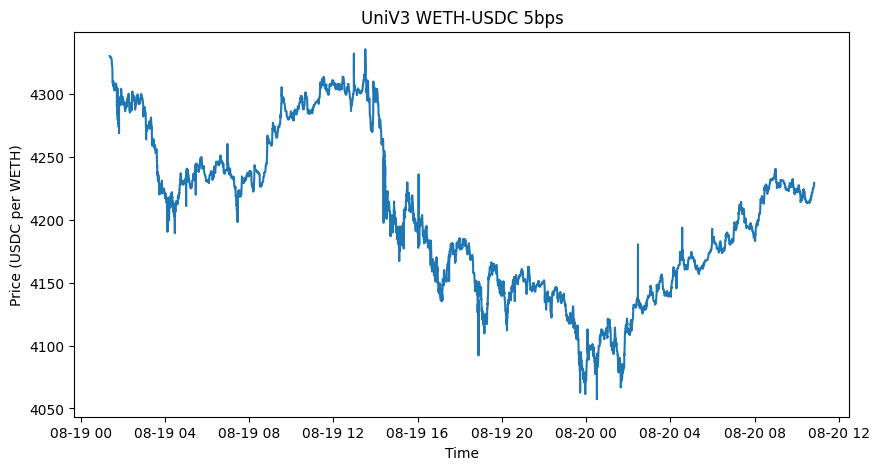

In [ ]:
# plot
plt.figure(figsize=(10,5))
plt.plot(df["timestamp"].to_numpy(), df["price"].to_numpy())
plt.xlabel("Time")
plt.ylabel("Price (USDC per WETH)")
plt.title("UniV3 WETH-USDC 5bps")
plt.grid(False)
plt.show()